[INFO] [1745545438.038231384] [rosbag2_storage]: Opened database '/home/andal/EECE5554/LAB4/Data/data_driving.bag/data_driving.bag_0.db3' for READ_ONLY.



--- Performance Metrics ---
RMSE (Easting + Northing): 531.54 m
Final Position Error: 531.00 m


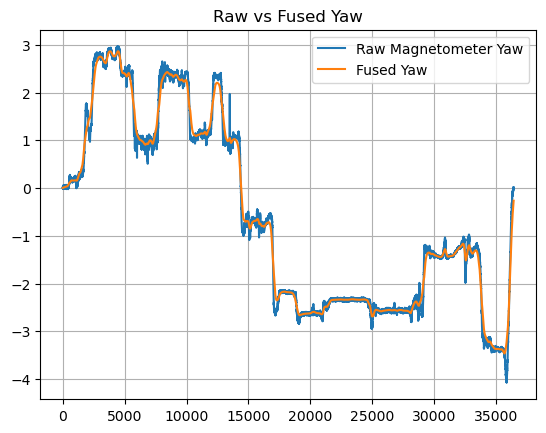

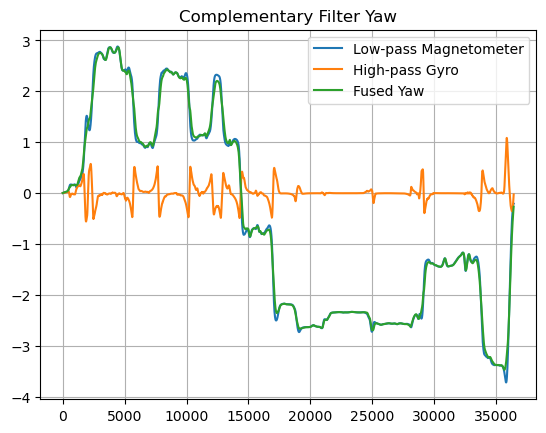

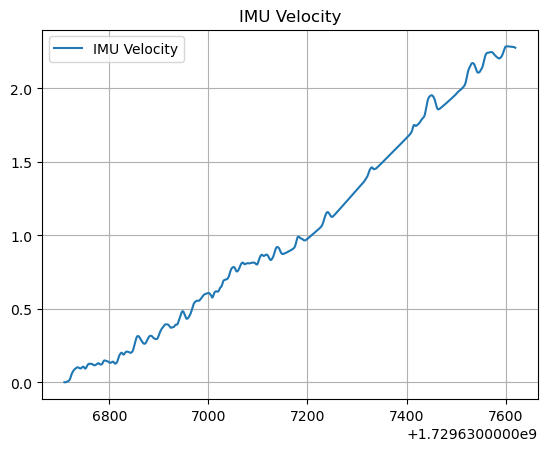

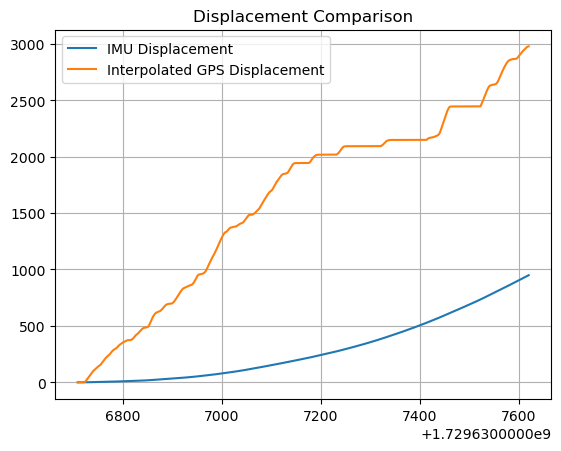

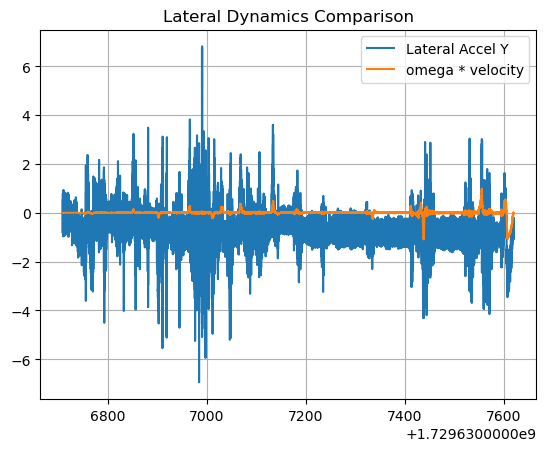

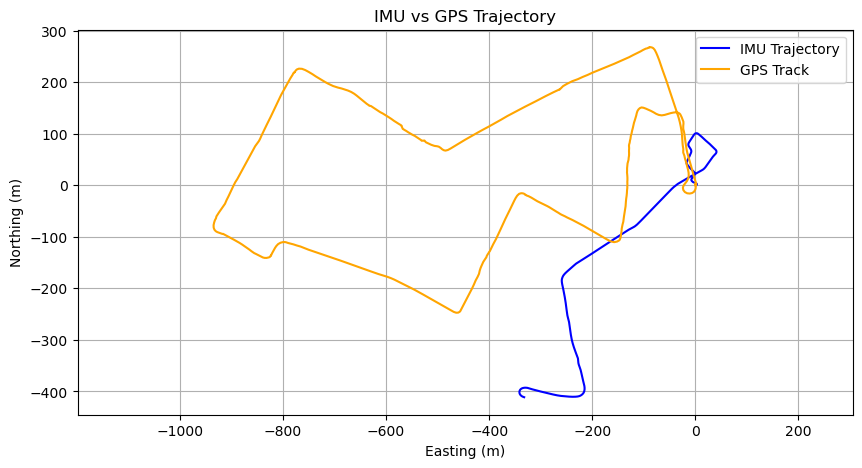

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.signal import butter, filtfilt
from gps_interfaces.msg import GPSmsg
from imu_interfaces.msg import IMUmsg
from rclpy.serialization import deserialize_message
import rosbag2_py
from rosidl_runtime_py.utilities import get_message
from sklearn.metrics import mean_squared_error

alpha = 0.95  # Complementary filter weight

# ---------------------- Data Loading ----------------------
def load_bag_data(bagfile_path):
    storage_options = rosbag2_py.StorageOptions(uri=bagfile_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions(input_serialization_format="cdr", output_serialization_format="cdr")
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    imu_data, gps_data = [], []
    while reader.has_next():
        topic, data, _ = reader.read_next()
        if topic == "/imu":
            imu_data.append(deserialize_message(data, IMUmsg))
        elif topic == "/gps":
            gps_data.append(deserialize_message(data, GPSmsg))

    return imu_data, gps_data

# ---------------------- Filters ----------------------
def butter_filter(data, cutoff, fs, filter_type):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(1, normal_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, data)

# ---------------------- Main Processing ----------------------
def process_data(bagfile_path):
    imu_data, gps_data = load_bag_data(bagfile_path)

    imu_time = np.array([msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9 for msg in imu_data])
    gyro_z = np.array([msg.imu.angular_velocity.z for msg in imu_data])
    accel_x = np.array([msg.imu.linear_acceleration.x for msg in imu_data])
    accel_y = np.array([msg.imu.linear_acceleration.y for msg in imu_data])
    mag_data = np.array([[msg.mag_field.magnetic_field.x, msg.mag_field.magnetic_field.y] for msg in imu_data]) * 1e7

    # ------------------ Part 1: Magnetometer Calibration ------------------
    offset_x = (np.max(mag_data[:, 0]) + np.min(mag_data[:, 0])) / 2
    offset_y = (np.max(mag_data[:, 1]) + np.min(mag_data[:, 1])) / 2
    mag_x_corrected = mag_data[:, 0] - offset_x
    mag_y_corrected = mag_data[:, 1] - offset_y
    scale_x = np.max(np.abs(mag_x_corrected))
    scale_y = np.max(np.abs(mag_y_corrected))
    scaling_factor = scale_x / scale_y
    mag_y_final = mag_y_corrected * scaling_factor
    mag_x_final = mag_x_corrected

    # ------------------ Part 2: Yaw Estimation ------------------
    yaw_mag = np.arctan2(mag_y_final, mag_x_final)
    yaw_mag = np.unwrap(yaw_mag)

    # Integrate gyro
    dt = np.diff(imu_time, prepend=imu_time[0])
    yaw_gyro = np.cumsum(gyro_z * dt)

    # Filtered Yaw using Complementary Filter (high-pass + low-pass)
    fs = 1.0 / np.mean(np.diff(imu_time))
    yaw_mag_low = butter_filter(yaw_mag, cutoff=0.08, fs=fs, filter_type='low')
    yaw_gyro_high = butter_filter(yaw_gyro, cutoff=0.03, fs=fs, filter_type='high')

    yaw_fused = np.zeros_like(yaw_mag)
    yaw_fused[0] = yaw_mag_low[0]
    for i in range(1, len(yaw_fused)):
        gyro_term = yaw_fused[i-1] + yaw_gyro_high[i] * dt[i]
        yaw_fused[i] = alpha * gyro_term + (1 - alpha) * yaw_mag_low[i]

    # ------------------ Velocity from Acceleration ------------------
    acc_filtered = butter_filter(accel_x, cutoff=0.1, fs=fs, filter_type='low')
    acc_bias = np.mean(acc_filtered[:100])
    acc_corrected = (acc_filtered - acc_bias) * 0.01
    velocity_imu = cumulative_trapezoid(acc_corrected, imu_time, initial=0)

    # ------------------ Dead Reckoning ------------------
    ve = velocity_imu * np.cos(yaw_fused)
    vn = velocity_imu * np.sin(yaw_fused)
    x_e = cumulative_trapezoid(ve, imu_time, initial=0)
    x_n = cumulative_trapezoid(vn, imu_time, initial=0)
    x_e -= x_e[0]
    x_n -= x_n[0]

    # ------------------ GPS Path ------------------
    gps_time = np.array([msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9 for msg in gps_data])
    utm_e = np.array([msg.utm_easting for msg in gps_data])
    utm_n = np.array([msg.utm_northing for msg in gps_data])
    gps_e = utm_e - utm_e[0]
    gps_n = utm_n - utm_n[0]

    # Align heading
    angle_offset = np.arctan2(gps_n[1] - gps_n[0], gps_e[1] - gps_e[0]) - yaw_fused[0]
    x_e_rot = x_e * np.cos(angle_offset) - x_n * np.sin(angle_offset)
    x_n_rot = x_e * np.sin(angle_offset) + x_n * np.cos(angle_offset)

    # ------------------ Compute Metrics ------------------
    min_len = min(len(x_e_rot), len(gps_e))
    mse_e = mean_squared_error(gps_e[:min_len], x_e_rot[:min_len])
    mse_n = mean_squared_error(gps_n[:min_len], x_n_rot[:min_len])
    rmse_total = np.sqrt(mse_e + mse_n)
    final_error = np.sqrt((gps_e[-1] - x_e_rot[-1])**2 + (gps_n[-1] - x_n_rot[-1])**2)

    print("\n--- Performance Metrics ---")
    print(f"RMSE (Easting + Northing): {rmse_total:.2f} m")
    print(f"Final Position Error: {final_error:.2f} m")

    # ------------------ Plotting ------------------
    plt.figure()
    plt.plot(yaw_mag, label='Raw Magnetometer Yaw')
    plt.plot(yaw_fused, label='Fused Yaw')
    plt.legend(); plt.grid(); plt.title("Raw vs Fused Yaw")

    plt.figure()
    plt.plot(yaw_mag_low, label='Low-pass Magnetometer')
    plt.plot(yaw_gyro_high, label='High-pass Gyro')
    plt.plot(yaw_fused, label='Fused Yaw')
    plt.legend(); plt.grid(); plt.title("Complementary Filter Yaw")

    plt.figure()
    plt.plot(imu_time, velocity_imu, label='IMU Velocity')
    plt.legend(); plt.grid(); plt.title("IMU Velocity")

    plt.figure()
    imu_disp = cumulative_trapezoid(velocity_imu, imu_time, initial=0)
    gps_disp = np.cumsum(np.insert(np.sqrt(np.diff(gps_e)**2 + np.diff(gps_n)**2), 0, 0))
    gps_interp = np.interp(imu_time, gps_time, gps_disp)
    plt.plot(imu_time, imu_disp, label='IMU Displacement')
    plt.plot(imu_time, gps_interp, label='Interpolated GPS Displacement')
    plt.legend(); plt.grid(); plt.title("Displacement Comparison")

    plt.figure()
    omega_velocity = gyro_z * velocity_imu
    plt.plot(imu_time, accel_y, label='Lateral Accel Y')
    plt.plot(imu_time, omega_velocity, label='omega * velocity')
    plt.legend(); plt.grid(); plt.title("Lateral Dynamics Comparison")

    plt.figure(figsize=(10, 5))
    plt.plot(x_e_rot, x_n_rot, label='IMU Trajectory', color='blue')
    plt.plot(gps_e, gps_n, label='GPS Track', color='orange')
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.title("IMU vs GPS Trajectory")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# ------------------ Run ------------------
bagfile_path = "/home/andal/EECE5554/LAB4/Data/data_driving.bag/data_driving.bag_0.db3"
process_data(bagfile_path)
